In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
import itertools

sns.set_palette('colorblind')
sns.set_style('white') 
palette = sns.color_palette('colorblind', 6)

### Using the median to separate two risk groups

In [74]:
# Read .csv files
norm_data = pd.read_csv('/Users/tk/Desktop/Research-CITS5014/csv/norm_data.csv')
meta_data = pd.read_csv('/Users/tk/Desktop/Research-CITS5014/csv/meta_data.csv')

norm_data.set_index(norm_data.columns[0], inplace=True)
norm_data.index.name = None
norm_data.columns = norm_data.columns.astype(int)

# Creat mapping dictionary
key_to_time = meta_data.set_index('sample_id_key')['survival_time'].to_dict()
key_to_time = {int(key): int(value) for key, value in key_to_time.items()}
key_to_status = meta_data.set_index('sample_id_key')['status'].to_dict()
key_to_subtype = meta_data.set_index('sample_id_key')['subtype'].to_dict()

# Create a dictionary to for gene id
gene_id = norm_data.index
gene_to_index = {gene: idx for idx, gene in enumerate(gene_id)}

In [75]:
# Create dictionary to map gene ID to gene name
df = pd.read_csv('./Raw_gene_count/0a9e33db-2527-4cc3-8669-a7c10fed7a7f.rna_seq.augmented_star_gene_counts.tsv', delimiter='\t', header=1)
df = df.iloc[4:]
gene_id_to_name = dict(zip(df['gene_id'], df['gene_name']))

#### Calculate the median for each gene

In [76]:
# Find median row-wise (each gene)
median_exp = norm_data.median(axis=1)
median_exp

ENSG00000000003.15    0.024842
ENSG00000000005.6     0.000110
ENSG00000000419.13    0.022194
ENSG00000000457.14    0.016291
ENSG00000000460.17    0.006789
                        ...   
ENSG00000288669.1     0.000000
ENSG00000288670.1     0.004142
ENSG00000288671.1     0.000000
ENSG00000288674.1     0.000065
ENSG00000288675.1     0.000238
Length: 60660, dtype: float64

In [77]:
gene_to_median = median_exp.to_dict()

#### KS test

In [78]:
# Convert to array
data = norm_data.values
columns_array = norm_data.columns.to_numpy()

results = []

for gene in gene_id:
    
    # Get the index for the gene
    gene_idx = gene_to_index[gene]

    # Get the row (normalised gene count) where index = gene
    row = data[gene_idx]

    # Get median expression of that gene
    median = gene_to_median[gene]
    
    # Initialize variables
    size_le = None
    size_he = None
    ks_stat = None
    ks_pval = None
    
    # Create masking
    le_mask = row <= median
    gt_mask = row > median

    # Extract column indices for each group
    group1_col = columns_array[le_mask]
    group2_col = columns_array[gt_mask]
        
    if len(group1_col) >= 1 and len(group2_col) >= 1:
        # Extract the survival time where index matches the column names
        time_group1 = [key_to_time.get(key) for key in group1_col]
        time_group2 = [key_to_time.get(key) for key in group2_col]

        # Perform KS test
        ks_test = ks_2samp(np.array(time_group1), np.array(time_group2))
        ks_stat = round(ks_test.statistic, 4)
        ks_pval = round(ks_test.pvalue, 4)
        size_le = len(time_group1)
        size_he = len(time_group2)

    # Store the results in the dictionary
    results.append({
        'gene': gene,
        'pvalue': ks_pval,
        'ks_statistic': ks_stat,
        'size_le': size_le,
        'size_he': size_he})

# Convert the results to a DataFrame
ks_median = pd.DataFrame(results)
ks_median.to_csv('./result/ks_median_two_groups.csv', index=False)

In [79]:
ks_median

,gene,pvalue,ks_statistic,size_le,size_he
0,ENSG00000000003.15,0.6309,0.0507,413.0,412.0
1,ENSG00000000005.6,0.9994,0.0241,413.0,412.0
2,ENSG00000000419.13,0.9994,0.0240,413.0,412.0
3,ENSG00000000457.14,0.9994,0.0241,413.0,412.0
4,ENSG00000000460.17,0.9999,0.0217,413.0,412.0
...,...,...,...,...,...
60655,ENSG00000288669.1,0.9958,0.0532,767.0,58.0
60656,ENSG00000288670.1,1.0000,0.0171,413.0,412.0
60657,ENSG00000288671.1,NaN,NaN,NaN,NaN
60658,ENSG00000288674.1,0.1629,0.0769,422.0,403.0


In [80]:
# Sort result by lowest p-value
ks_result = ks_median.sort_values(by='pvalue')
ks_result.head(10)

,gene,pvalue,ks_statistic,size_le,size_he
47381,ENSG00000263581.1,0.0024,1.0000,824.0,1.0
17651,ENSG00000198133.8,0.0041,0.1210,413.0,412.0
54700,ENSG00000278197.1,0.0146,0.9162,823.0,2.0
13174,ENSG00000171914.16,0.0164,0.1063,413.0,412.0
36892,ENSG00000243738.3,0.0164,0.1063,413.0,412.0
17264,ENSG00000196954.14,0.0164,0.1064,413.0,412.0
22092,ENSG00000212951.5,0.0170,0.9927,824.0,1.0
7473,ENSG00000137474.22,0.0203,0.1039,413.0,412.0
2979,ENSG00000104856.14,0.0203,0.1039,413.0,412.0
2910,ENSG00000104368.19,0.0203,0.1040,413.0,412.0


In [81]:
# Get gene list with 
p = 0.02
gene_list = ks_result.loc[ks_result['pvalue'] <= p].iloc[:, 0]
for gene in gene_list:
    print(gene_id_to_name.get(gene, gene))

MIR548X2
TMEM229B
AC006338.1
TLN2
RN7SL181P
CASP4
BX005266.1


In [82]:
df_with_subtype = pd.read_csv('/Users/tk/Desktop/gene_project/norm_pam50.csv', sep=',', index_col=0, low_memory=False)
df_with_subtype.index.name = None

# Get survival time, status, and subtype from the dataframe
survival_time = pd.to_numeric(df_with_subtype.iloc[-3].values, errors='coerce')
status = pd.to_numeric(df_with_subtype.iloc[-2].values, errors='coerce')
subtypes = df_with_subtype.iloc[-1].values

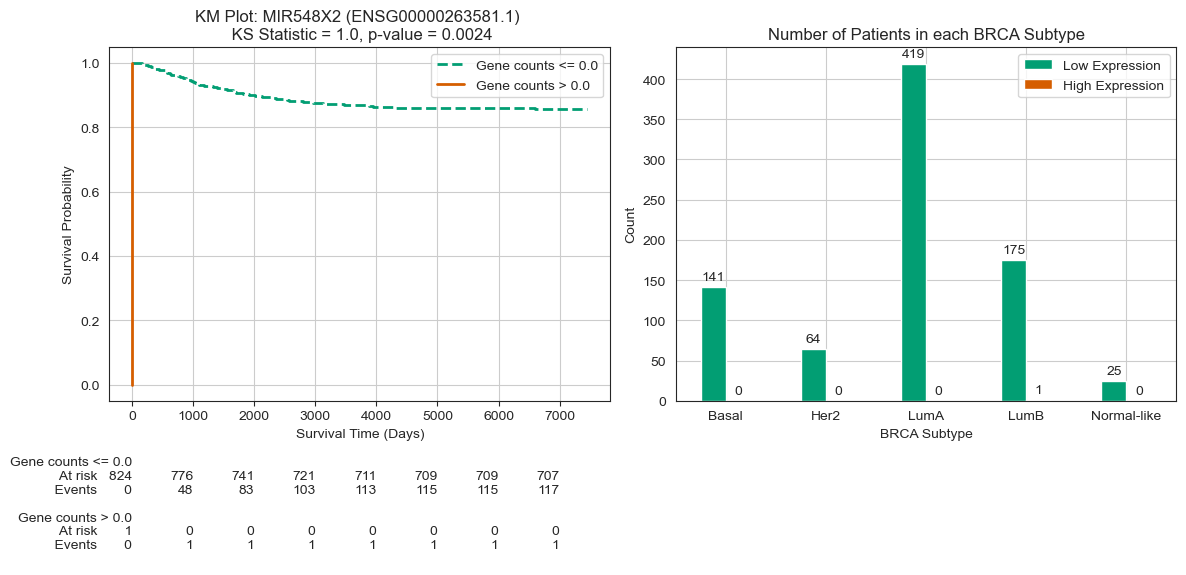

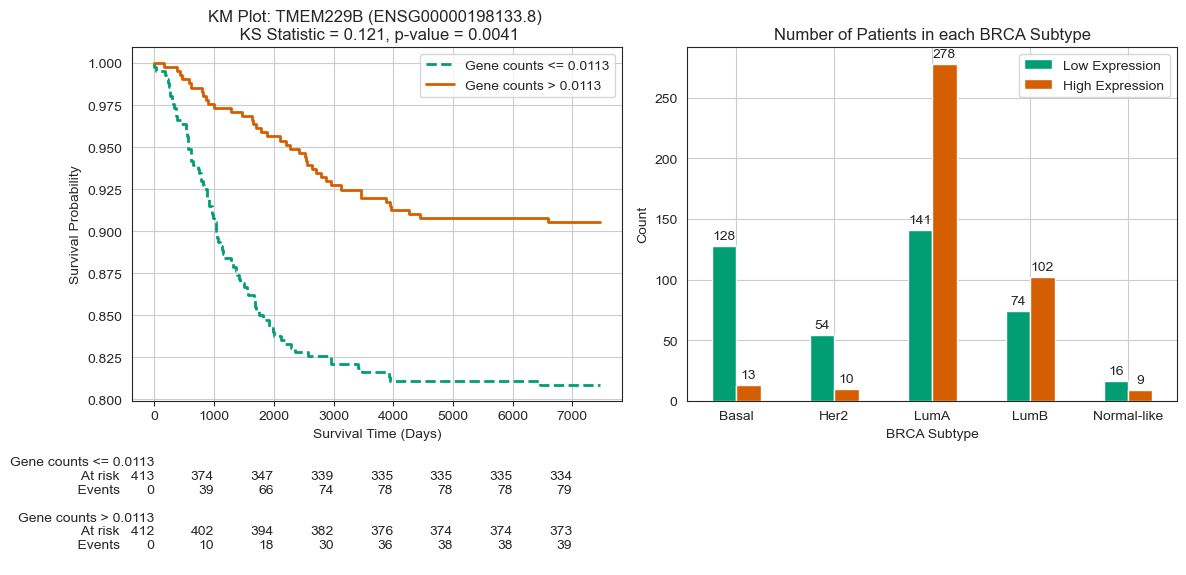

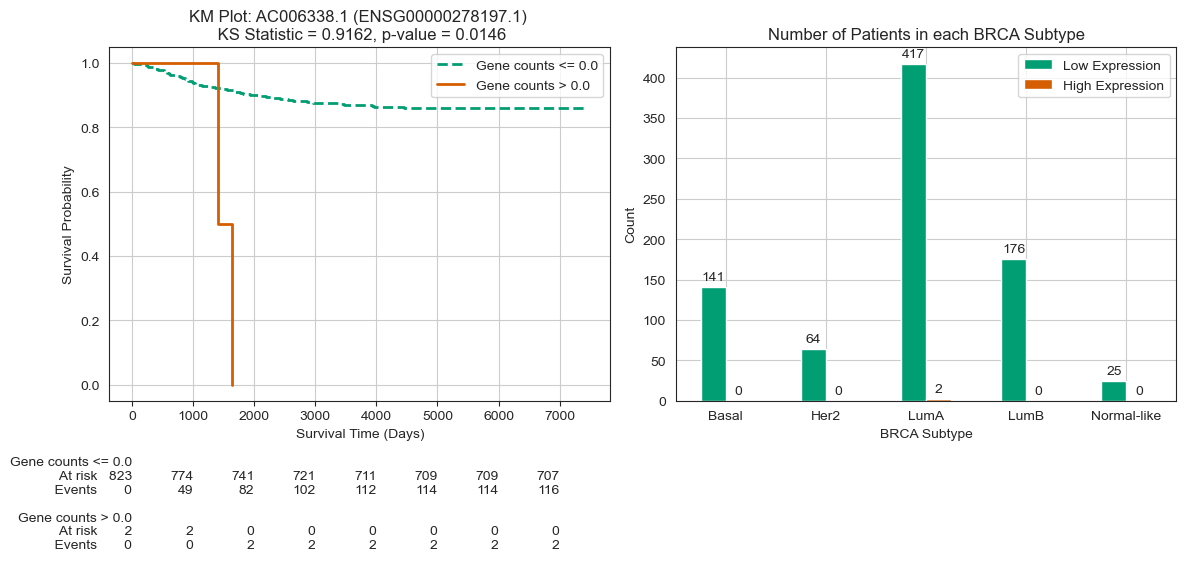

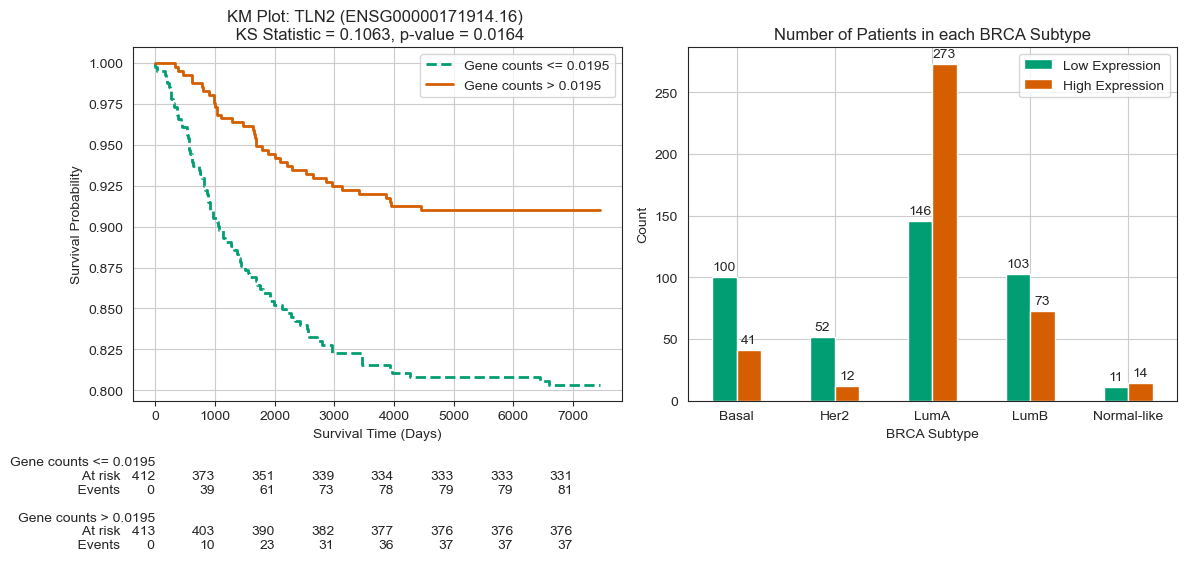

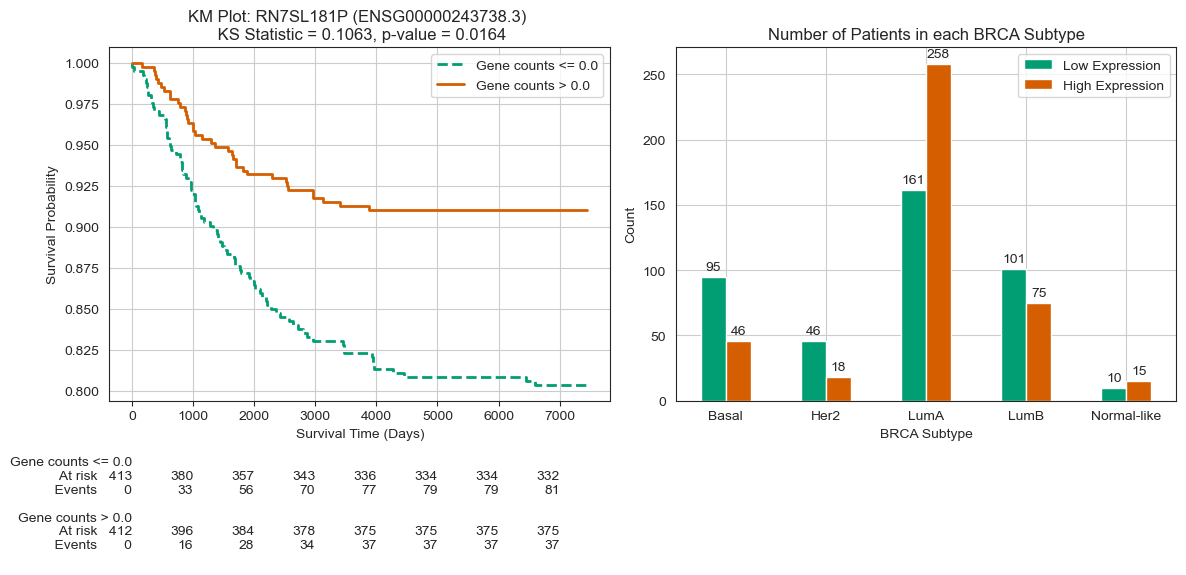

In [83]:
# Plot KM curves
for i, gene in enumerate(gene_list[:5]):

    # Get gene count of that gene
    row = pd.to_numeric(df_with_subtype.loc[gene].values, errors='coerce')

    # Get optimal threshold for that gene
    tbl = ks_result[ks_result['gene'] == gene]
    median = gene_to_median[gene]

    # Extract days to death
    time_g1 = survival_time[row <= median]
    time_g2 = survival_time[row > median]
    
    # Extract status
    status_g1 = status[row <= median]
    status_g2 = status[row > median]

    # Extract KS_statistics
    ks_stat = round(tbl['ks_statistic'].values[0], 4)
    ks_pval = round(tbl['pvalue'].values[0], 4)
    text = f"KS Statistic = {ks_stat}, p-value = {ks_pval}"

    # Fit KaplanMeierFitter
    kmf_1 = KaplanMeierFitter()
    kmf_2 = KaplanMeierFitter()
    kmf_1.fit(time_g1, status_g1, label=f"Gene counts <= {round(median, 4)}")
    kmf_2.fit(time_g2, status_g2, label=f"Gene counts > {round(median, 4)}")

    # Plot Kaplan-Meier survival functions
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Top subplot
    ax = axs[0]
    kmf_1.plot_survival_function(ax=ax, ci_show=False, linestyle='dashed', linewidth=2, color=sns.color_palette('colorblind')[2])
    kmf_2.plot_survival_function(ax=ax, ci_show=False, linestyle='solid', linewidth=2, color=sns.color_palette('colorblind')[3])
    add_at_risk_counts(kmf_1, kmf_2, ax=ax, rows_to_show=['At risk', 'Events'])

    ax.set_title(f"KM Plot: {gene_id_to_name.get(gene, gene)} ({gene}) \n {text}")
    ax.set_xlabel("Survival Time (Days)")
    ax.set_ylabel("Survival Probability")
    ax.grid(True)
    ax.legend()
    
    # Plot number of samples in each subtype
    # Extract subtypes
    type_g1 = subtypes[row <= median]
    type_g2 = subtypes[row > median]

    # Count occurrences of each unique type
    unique_values = np.unique(np.concatenate([type_g1, type_g2]))

    # Count occurrences for each unique value in type_g1 and type_g2
    counts_type1 = np.array([np.count_nonzero(type_g1 == val) for val in unique_values])
    counts_type2 = np.array([np.count_nonzero(type_g2 == val) for val in unique_values])

    # Create a DataFrame directly
    df = pd.DataFrame({
        'Count': unique_values,
        'Low Expression': counts_type1,
        'High Expression': counts_type2
    }).set_index('Count')

    # Bottom subplot
    ax = axs[1]
    df.plot(kind='bar', color=[palette[2], palette[3]], ax=ax)
    # Add numbers on top of the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline',
                    xytext=(0, 5),
                    textcoords='offset points')
    ax.set_xlabel('BRCA Subtype')
    ax.set_xticklabels(df.index, rotation=0)
    ax.set_ylabel('Count')
    ax.set_title('Number of Patients in each BRCA Subtype')
    ax.grid()
    plt.tight_layout()
    plt.show()

#### JS Divergence

In [84]:
min_group_size = 1
epsilon = 1e-10
results = []

for gene in gene_id:
    
    # Get the index for the gene
    gene_idx = gene_to_index[gene]
    
    # Get the row where index = gene
    row = data[gene_idx]
    
    # Get median expression of that gene
    median = gene_to_median[gene]
    
    # Initialize variables
    JSD = None
    
    # Create masking
    le_mask = row <= median
    gt_mask = row > median

    # Extract column indices for each group
    group1_col = columns_array[le_mask]
    group2_col = columns_array[gt_mask]

    if len(group1_col) >= min_group_size and len(group2_col) >= min_group_size:
        # Extract the survival time where index matches the column names
        time_group1 = [key_to_time.get(key) for key in group1_col]
        time_group2 = [key_to_time.get(key) for key in group2_col]
        
        # Combine both time groups to get all unique time values
        all_times = list(set(time_group1 + time_group2))
        # Calculate the probability distribution for each group
        p = pd.Series(time_group1).value_counts(normalize=True).reindex(all_times, fill_value=0)
        q = pd.Series(time_group2).value_counts(normalize=True).reindex(all_times, fill_value=0)
        p = np.clip(p, epsilon, None)
        q = np.clip(q, epsilon, None)
        
        # Compute the average distribution
        m = 0.5 * (p + q)
        # Calculate KL Divergences
        KL_P_M = np.sum(p * np.log(p / m))
        KL_Q_M = np.sum(q * np.log(q / m))
        # Calculate JS divergence
        JSD = 0.5 * (KL_P_M + KL_Q_M)

    # Store the results in the dictionary
    results.append({
        'gene': gene,
        'JSD': JSD,
        'size_le': len(time_group1),
        'size_he': len(time_group2)})

# Convert the results to a DataFrame
jsd_median = pd.DataFrame(results)
jsd_median.to_csv('./result/jsd_median_two_groups.csv', index=False)

In [85]:
jsd_median

,gene,JSD,size_le,size_he
0,ENSG00000000003.15,0.099164,413,412
1,ENSG00000000005.6,0.096828,413,412
2,ENSG00000000419.13,0.095219,413,412
3,ENSG00000000457.14,0.096849,413,412
4,ENSG00000000460.17,0.095154,413,412
...,...,...,...,...
60655,ENSG00000288669.1,0.097512,767,58
60656,ENSG00000288670.1,0.096828,413,412
60657,ENSG00000288671.1,NaN,413,412
60658,ENSG00000288674.1,0.096986,422,403


In [86]:
# Sort result by JSD
jsd_result = jsd_median.sort_values(by='JSD', ascending=False)
jsd_result.head(10)

,gene,JSD,size_le,size_he
38207,ENSG00000249104.3,0.693147,824,1
24981,ENSG00000223889.1,0.693147,824,1
49081,ENSG00000267125.2,0.693147,824,1
47652,ENSG00000264115.1,0.693147,824,1
57339,ENSG00000284071.1,0.693147,824,1
31430,ENSG00000233378.1,0.693147,824,1
54734,ENSG00000278265.1,0.693147,824,1
52395,ENSG00000273589.1,0.693147,824,1
38456,ENSG00000249501.1,0.693147,824,1
46202,ENSG00000260845.1,0.693147,824,1


In [87]:
# Get top gene lists
cutoff = 0.69
gene_list = jsd_result.loc[jsd_result['JSD'] >= cutoff].iloc[:, 0]
print(len(gene_list))
for gene in gene_list:
    print(gene_id_to_name.get(gene, gene))

29
USP17L17
AC073188.1
AC012615.3
MIR3180-4
AC012005.2
USP9YP34
MIR6770-1
AC008175.2
USP9YP2
AC138907.2
MIR3670-2
OFD1P16Y
SMIM40
DEFT1P2
AC138907.3
SDR42E1P4
BX005195.1
OR4F8P
SNORA70
MIR548AI
RBMY1E
AC133485.3
MIR548X2
RNU6-1076P
RNU6-1117P
BPY2C
RBMY2EP
BX005266.1
AC006338.1


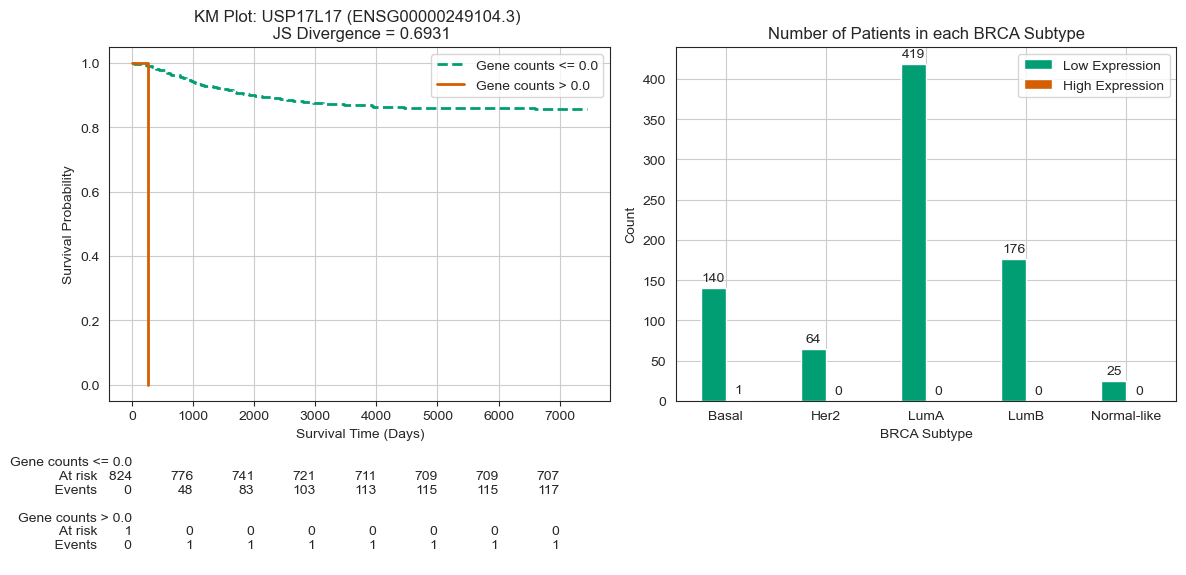

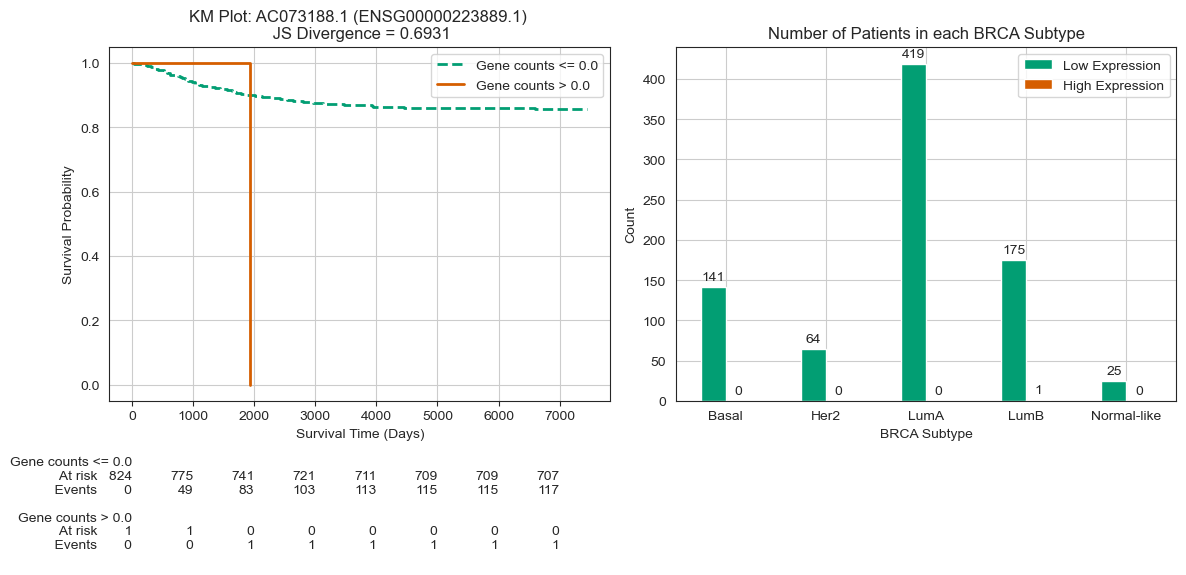

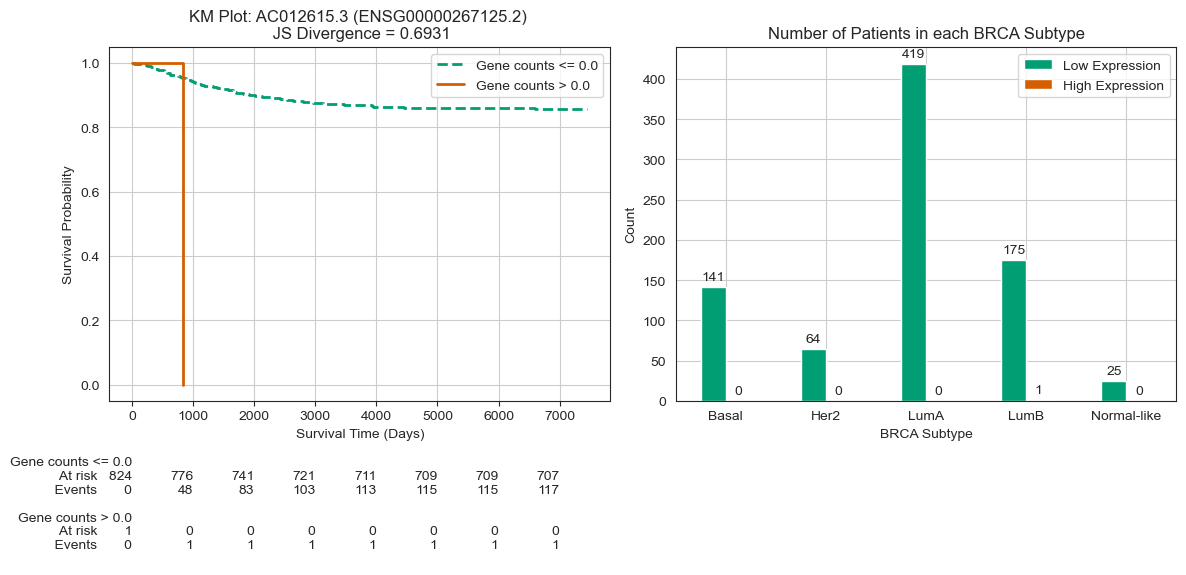

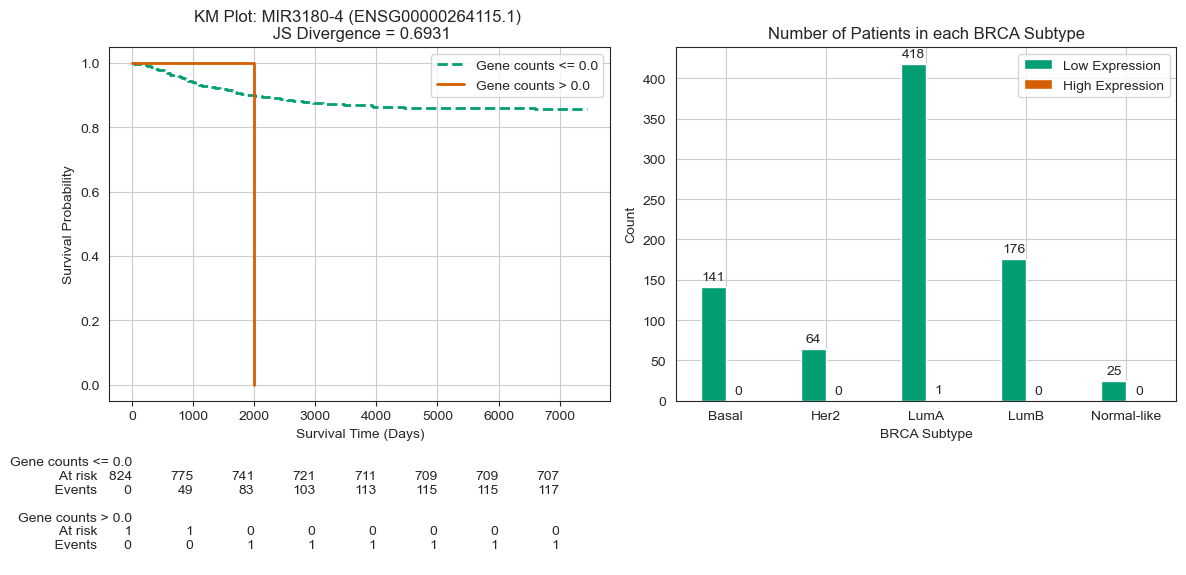

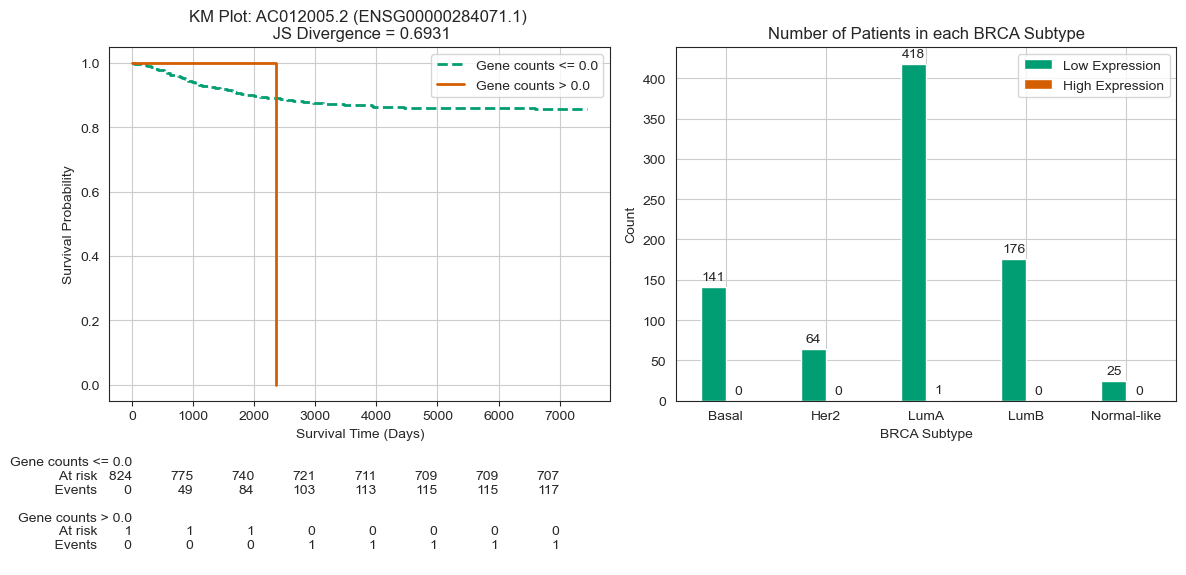

In [88]:
for i, gene in enumerate(gene_list[:5]):

    # Get gene count of that gene
    row = pd.to_numeric(df_with_subtype.loc[gene].values, errors='coerce')

    # Get optimal threshold for that gene
    tbl = jsd_result[jsd_result['gene'] == gene]
    median = gene_to_median[gene]

    # Extract days to death
    time_g1 = survival_time[row <= median]
    time_g2 = survival_time[row > median]
    
    # Extract status
    status_g1 = status[row <= median]
    status_g2 = status[row > median]

    # Extract KS_statistics
    jsd = round(tbl['JSD'].values[0], 4)
    text = f"JS Divergence = {jsd}"

    # Fit KaplanMeierFitter
    kmf_1 = KaplanMeierFitter()
    kmf_2 = KaplanMeierFitter()
    kmf_1.fit(time_g1, status_g1, label=f"Gene counts <= {round(median, 4)}")
    kmf_2.fit(time_g2, status_g2, label=f"Gene counts > {round(median, 4)}")

    # Plot Kaplan-Meier survival functions
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Top subplot
    ax = axs[0]
    kmf_1.plot_survival_function(ax=ax, ci_show=False, linestyle='dashed', linewidth=2, color=sns.color_palette('colorblind')[2])
    kmf_2.plot_survival_function(ax=ax, ci_show=False, linestyle='solid', linewidth=2, color=sns.color_palette('colorblind')[3])
    add_at_risk_counts(kmf_1, kmf_2, ax=ax, rows_to_show=['At risk', 'Events'])

    ax.set_title(f"KM Plot: {gene_id_to_name.get(gene, gene)} ({gene}) \n {text}")
    ax.set_xlabel("Survival Time (Days)")
    ax.set_ylabel("Survival Probability")
    ax.grid(True)
    ax.legend()
    
    # Plot number of samples in each subtype
    # Extract subtypes
    type_g1 = subtypes[row <= median]
    type_g2 = subtypes[row > median]

    # Count occurrences of each unique type
    unique_values = np.unique(np.concatenate([type_g1, type_g2]))

    # Count occurrences for each unique value in type_g1 and type_g2
    counts_type1 = np.array([np.count_nonzero(type_g1 == val) for val in unique_values])
    counts_type2 = np.array([np.count_nonzero(type_g2 == val) for val in unique_values])

    # Create a DataFrame directly
    df = pd.DataFrame({
        'Count': unique_values,
        'Low Expression': counts_type1,
        'High Expression': counts_type2
    }).set_index('Count')

    # Bottom subplot
    ax = axs[1]
    df.plot(kind='bar', color=[palette[2], palette[3]], ax=ax)
    # Add numbers on top of the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline',
                    xytext=(0, 5),
                    textcoords='offset points')
    ax.set_xlabel('BRCA Subtype')
    ax.set_xticklabels(df.index, rotation=0)
    ax.set_ylabel('Count')
    ax.set_title('Number of Patients in each BRCA Subtype')
    ax.grid()
    plt.tight_layout()
    plt.show()

### Using the median to separate three risk groups

#### KS test

In [89]:
min = norm_data.shape[1]*0.45
results = []

for gene in gene_id:
    
    # Get the index for the gene
    gene_idx = gene_to_index[gene]

    # Get the row (normalised gene count) where index = gene
    row = data[gene_idx]

    # Get median expression of that gene
    median = gene_to_median[gene]
    
    # Initialize variables
    size_le = None
    size_he = None
    ks_stat = None
    ks_pval = None
    
    # Create masking
    mask_1 = row < median
    mask_2 = row == median
    mask_3 = row > median

    # Extract column indices for each group
    group1_col = columns_array[mask_1]
    group2_col = columns_array[mask_2]
    group3_col = columns_array[mask_3]

    # Create a list of groups
    groups = [group1_col, group2_col, group3_col]

    # Initialize a list to store valid combinations
    valid_combinations = []

    # Iterate through all combinations of 2 groups
    for group_combination in itertools.combinations(groups, 2):
        # Check if both groups have more than 6 members
        if len(group_combination[0]) >=  min and len(group_combination[1]) >= min:
            valid_combinations.append(group_combination)

    # Store the valid combination
    if valid_combinations:
        group1_col, group2_col = valid_combinations[0]  # Get the valid combination
        
    if len(group1_col) >= 1 and len(group2_col) >= 1:
        # Extract the survival time where index matches the column names
        time_group1 = [key_to_time.get(key) for key in group1_col]
        time_group2 = [key_to_time.get(key) for key in group2_col]

        # Perform KS test
        ks_test = ks_2samp(np.array(time_group1), np.array(time_group2))
        ks_stat = round(ks_test.statistic, 4)
        ks_pval = round(ks_test.pvalue, 4)
        size_le = len(time_group1)
        size_he = len(time_group2)

    # Store the results in the dictionary
    results.append({
        'gene': gene,
        'pvalue': ks_pval,
        'ks_statistic': ks_stat,
        'size_le': size_le,
        'size_he': size_he})

# Convert the results to a DataFrame
ks_median = pd.DataFrame(results)
ks_median.to_csv('./result/ks_median_three_groups.csv', index=False)

/var/folders/nn/n9lqp7fs1pq402h_v1c984h40000gn/T/ipykernel_90989/3902965583.py:53: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  ks_test = ks_2samp(np.array(time_group1), np.array(time_group2))


In [90]:
ks_median

,gene,pvalue,ks_statistic,size_le,size_he
0,ENSG00000000003.15,0.6589,0.0510,412.0,412.0
1,ENSG00000000005.6,0.9991,0.0248,409.0,412.0
2,ENSG00000000419.13,0.9997,0.0243,412.0,412.0
3,ENSG00000000457.14,0.9997,0.0243,412.0,412.0
4,ENSG00000000460.17,1.0000,0.0218,412.0,412.0
...,...,...,...,...,...
60655,ENSG00000288669.1,NaN,NaN,NaN,NaN
60656,ENSG00000288670.1,1.0000,0.0170,412.0,412.0
60657,ENSG00000288671.1,NaN,NaN,NaN,NaN
60658,ENSG00000288674.1,0.1526,0.0783,412.0,403.0


In [91]:
# Sort result by p-value
ks_result = ks_median.sort_values(by='pvalue')
ks_result.head(10)
# Filter result with balanced number of sample in each group
# ks_result = ks_result.sort_values(by='ks_statistic', ascending=False)

,gene,pvalue,ks_statistic,size_le,size_he
17651,ENSG00000198133.8,0.0046,0.1214,412.0,412.0
36892,ENSG00000243738.3,0.0169,0.1068,407.0,412.0
13174,ENSG00000171914.16,0.0181,0.1068,412.0,412.0
7473,ENSG00000137474.22,0.0224,0.1044,412.0,412.0
2910,ENSG00000104368.19,0.0224,0.1044,412.0,412.0
17264,ENSG00000196954.14,0.0224,0.1044,412.0,412.0
24232,ENSG00000222267.1,0.0244,0.1032,401.0,407.0
56698,ENSG00000282951.1,0.0259,0.1018,411.0,409.0
8194,ENSG00000142082.15,0.0276,0.1019,412.0,412.0
6205,ENSG00000130045.16,0.0276,0.1019,412.0,412.0


In [92]:
# Get top gene lists
p = 0.02
gene_list = ks_result.loc[ks_result['pvalue'] <= p].iloc[:, 0]
for gene in gene_list:
    print(gene_id_to_name.get(gene, gene))

TMEM229B
RN7SL181P
TLN2


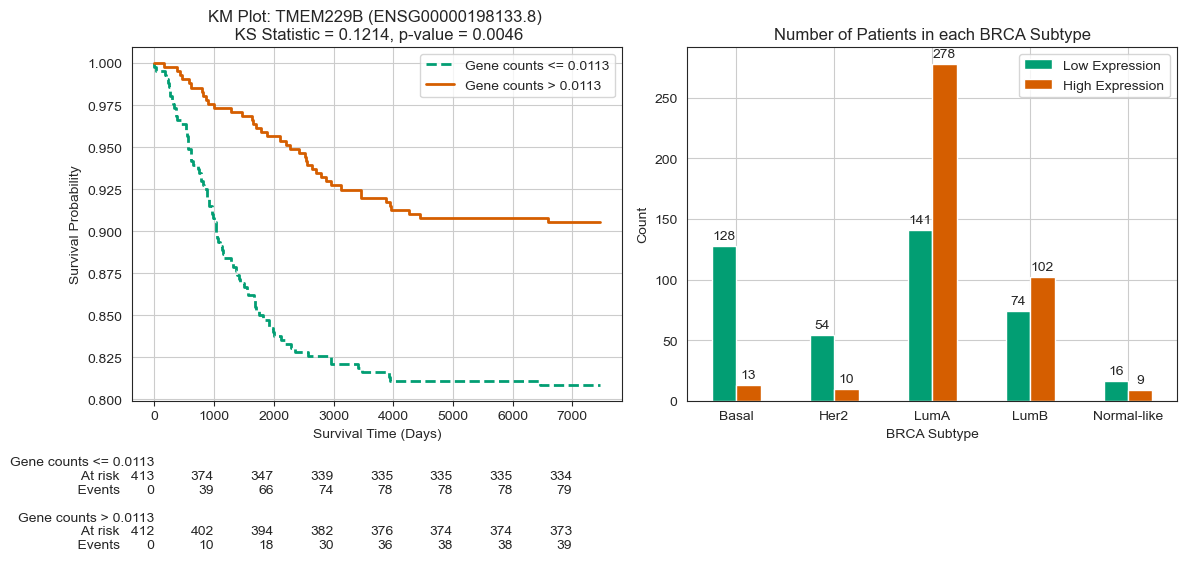

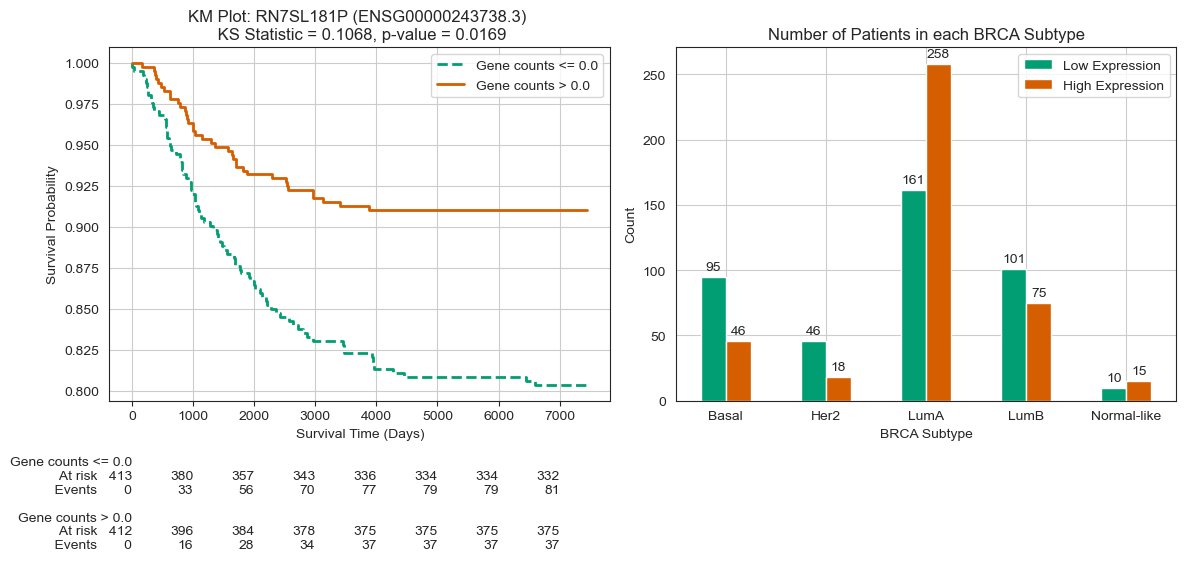

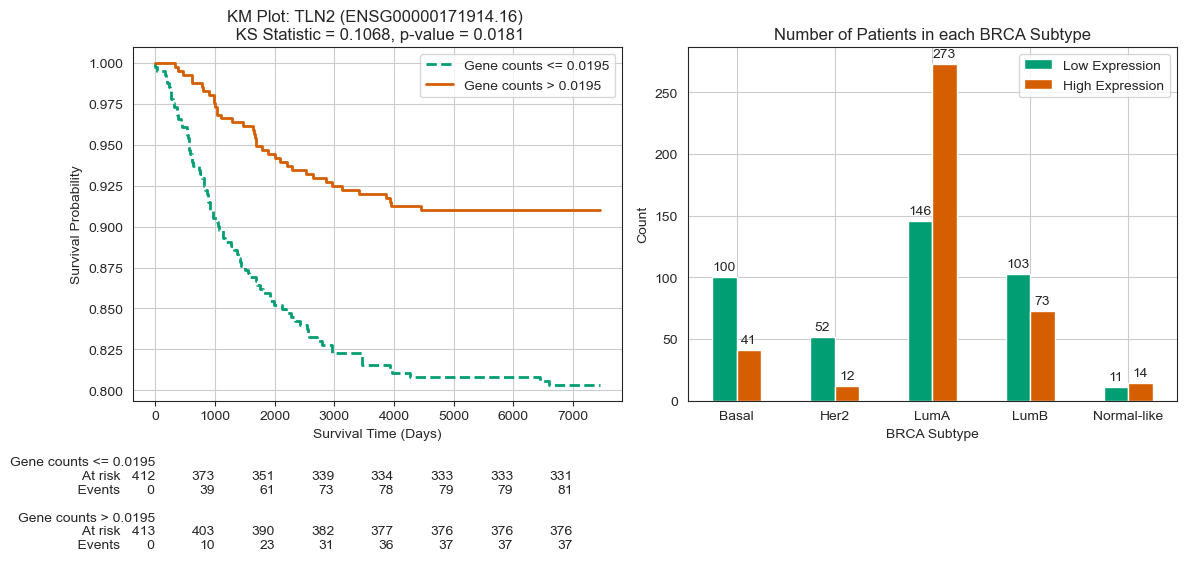

In [93]:
for i, gene in enumerate(gene_list[:5]):

    # Get gene count of that gene
    row = pd.to_numeric(df_with_subtype.loc[gene].values, errors='coerce')

    # Get optimal threshold for that gene
    tbl = ks_result[ks_result['gene'] == gene]
    median = gene_to_median[gene]

    # Extract days to death
    time_g1 = survival_time[row <= median]
    time_g2 = survival_time[row > median]
    
    # Extract status
    status_g1 = status[row <= median]
    status_g2 = status[row > median]

    # Extract KS_statistics
    ks_stat = round(tbl['ks_statistic'].values[0], 4)
    ks_pval = round(tbl['pvalue'].values[0], 4)
    text = f"KS Statistic = {ks_stat}, p-value = {ks_pval}"

    # Fit KaplanMeierFitter
    kmf_1 = KaplanMeierFitter()
    kmf_2 = KaplanMeierFitter()
    kmf_1.fit(time_g1, status_g1, label=f"Gene counts <= {round(median, 4)}")
    kmf_2.fit(time_g2, status_g2, label=f"Gene counts > {round(median, 4)}")

    # Plot Kaplan-Meier survival functions
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Top subplot
    ax = axs[0]
    kmf_1.plot_survival_function(ax=ax, ci_show=False, linestyle='dashed', linewidth=2, color=sns.color_palette('colorblind')[2])
    kmf_2.plot_survival_function(ax=ax, ci_show=False, linestyle='solid', linewidth=2, color=sns.color_palette('colorblind')[3])
    add_at_risk_counts(kmf_1, kmf_2, ax=ax, rows_to_show=['At risk', 'Events'])

    ax.set_title(f"KM Plot: {gene_id_to_name.get(gene, gene)} ({gene}) \n {text}")
    ax.set_xlabel("Survival Time (Days)")
    ax.set_ylabel("Survival Probability")
    ax.grid(True)
    ax.legend()
    
    # Plot number of samples in each subtype
    # Extract subtypes
    type_g1 = subtypes[row <= median]
    type_g2 = subtypes[row > median]

    # Count occurrences of each unique type
    unique_values = np.unique(np.concatenate([type_g1, type_g2]))

    # Count occurrences for each unique value in type_g1 and type_g2
    counts_type1 = np.array([np.count_nonzero(type_g1 == val) for val in unique_values])
    counts_type2 = np.array([np.count_nonzero(type_g2 == val) for val in unique_values])

    # Create a DataFrame directly
    df = pd.DataFrame({
        'Count': unique_values,
        'Low Expression': counts_type1,
        'High Expression': counts_type2
    }).set_index('Count')

    # Bottom subplot
    ax = axs[1]
    df.plot(kind='bar', color=[palette[2], palette[3]], ax=ax)
    # Add numbers on top of the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline',
                    xytext=(0, 5),
                    textcoords='offset points')
    ax.set_xlabel('BRCA Subtype')
    ax.set_xticklabels(df.index, rotation=0)
    ax.set_ylabel('Count')
    ax.set_title('Number of Patients in each BRCA Subtype')
    ax.grid()
    plt.tight_layout()
    plt.show()

#### JS Divergence

In [94]:
epsilon = 1e-10
results = []

for gene in gene_id:
    
    # Get the index for the gene
    gene_idx = gene_to_index[gene]
    
    # Get the row where index = gene
    row = data[gene_idx]
    
    # Get median expression of that gene
    median = gene_to_median[gene]
    
    # Initialize variables
    JSD = None
    
    # Create masking
    mask_1 = row < median
    mask_2 = row == median
    mask_3 = row > median

    # Extract column indices for each group
    group1_col = columns_array[mask_1]
    group2_col = columns_array[mask_2]
    group3_col = columns_array[mask_3]

    # Create a list of groups
    groups = [group1_col, group2_col, group3_col]

    # Initialize a list to store valid combinations
    valid_combinations = []

    # Iterate through all combinations of 2 groups
    for group_combination in itertools.combinations(groups, 2):
        # Check if both groups have more than 6 members
        if len(group_combination[0]) >=  min and len(group_combination[1]) >= min:
            valid_combinations.append(group_combination)

    # Store the valid combination
    if valid_combinations:
        group1_col, group2_col = valid_combinations[0]  # Get the valid combination

    if len(group1_col) >= 1 and len(group2_col) >= 1:
        # Extract the survival time where index matches the column names
        time_group1 = [key_to_time.get(key) for key in group1_col]
        time_group2 = [key_to_time.get(key) for key in group2_col]
        
        # Combine both time groups to get all unique time values
        all_times = list(set(time_group1 + time_group2))
        # Calculate the probability distribution for each group
        p = pd.Series(time_group1).value_counts(normalize=True).reindex(all_times, fill_value=0)
        q = pd.Series(time_group2).value_counts(normalize=True).reindex(all_times, fill_value=0)
        p = np.clip(p, epsilon, None)
        q = np.clip(q, epsilon, None)
        
        # Compute the average distribution
        m = 0.5 * (p + q)
        # Calculate KL Divergences
        KL_P_M = np.sum(p * np.log(p / m))
        KL_Q_M = np.sum(q * np.log(q / m))
        # Calculate JS divergence
        JSD = 0.5 * (KL_P_M + KL_Q_M)

    # Store the results in the dictionary
    results.append({
        'gene': gene,
        'JSD': JSD,
        'size_le': len(time_group1),
        'size_he': len(time_group2)})

# Convert the results to a DataFrame
jsd_median = pd.DataFrame(results)
jsd_median.to_csv('./result/jsd_median_three_groups.csv', index=False)

In [95]:
jsd_median

,gene,JSD,size_le,size_he
0,ENSG00000000003.15,0.099292,412,412
1,ENSG00000000005.6,0.097309,409,412
2,ENSG00000000419.13,0.095347,412,412
3,ENSG00000000457.14,0.096975,412,412
4,ENSG00000000460.17,0.095275,412,412
...,...,...,...,...
60655,ENSG00000288669.1,NaN,411,412
60656,ENSG00000288670.1,0.096947,412,412
60657,ENSG00000288671.1,NaN,412,412
60658,ENSG00000288674.1,0.096764,412,403


In [96]:
# Sort result by JSD
jsd_result = jsd_median.sort_values(by='JSD', ascending=False)
jsd_result.head(10)

,gene,JSD,size_le,size_he
34467,ENSG00000237828.1,0.137537,371,45
44803,ENSG00000259022.2,0.103126,385,403
25460,ENSG00000224598.1,0.102556,411,385
48163,ENSG00000265261.1,0.102502,378,406
54885,ENSG00000278588.2,0.102334,385,408
40340,ENSG00000252334.1,0.102090,398,398
52827,ENSG00000274444.1,0.102061,386,411
51893,ENSG00000272672.1,0.101977,409,385
23500,ENSG00000217889.3,0.101928,399,412
59662,ENSG00000287257.1,0.101888,410,392


In [97]:
# Get top gene lists
cutoff = 0.10
gene_list = jsd_result.loc[jsd_result['JSD'] >= cutoff].iloc[:, 0]
print(len(gene_list))
for gene in gene_list:
    print(gene_id_to_name.get(gene, gene))

349
PA2G4P1
DNAJC8P1
RPS5P2
AC027575.1
H2BC10
RNU6-1337P
AC078909.2
AL391497.1
KRT18P48
AC111182.2
SCUBE1-AS2
AC079160.1
AC112187.3
PHBP13
AC138305.3
AC020658.6
AC092139.2
AC010547.1
AC122718.2
AL121985.1
AC007292.3
IGHV3OR16-10
OR2AE1
CFL1P4
HNRNPA1P15
MORF4L1P3
CHORDC1P4
AC080038.2
AC096536.1
AC005244.1
BTF3P4
RPL7P37
TET2-AS1
C1orf195
BX322635.1
ANP32AP1
LINC02818
HDAC1P2
THAP12P3
AC099336.1
FAF1-AS1
PPP1R2P6
NPPA
LINC00906
ST7-OT4
AC103681.2
AL353138.1
DCAF13P1
UBE2V1P1
AC130343.3
AC009949.1
CDC42P5
IGHV3OR16-12
KRT8P2
AC004801.1
AL590787.1
SCARNA9
AC005225.2
IGKV1D-27
SEL1L2
AL049780.2
AC005280.1
HCG17
AC007370.2
HNRNPA1P62
GABRB1
AC018797.2
AC004637.1
AL158070.1
AC092268.1
LINC02240
AC006978.2
TICAM2
AC097372.2
AC092447.2
AC084128.1
ST13P13
AL139289.2
TRIM50
TRBV7-4
RYKP1
AC007906.1
AC005086.2
AL357143.1
UBE2NL
AC009312.1
AL355032.1
TCEAL6
AL137782.1
AC107081.2
AL845552.2
AF127577.6
DNAJB5-DT
AC097637.2
TMEM211
AC135178.1
AL008628.1
AC009951.4
CELA2A
AC092171.1
AC127502.3
AC13846

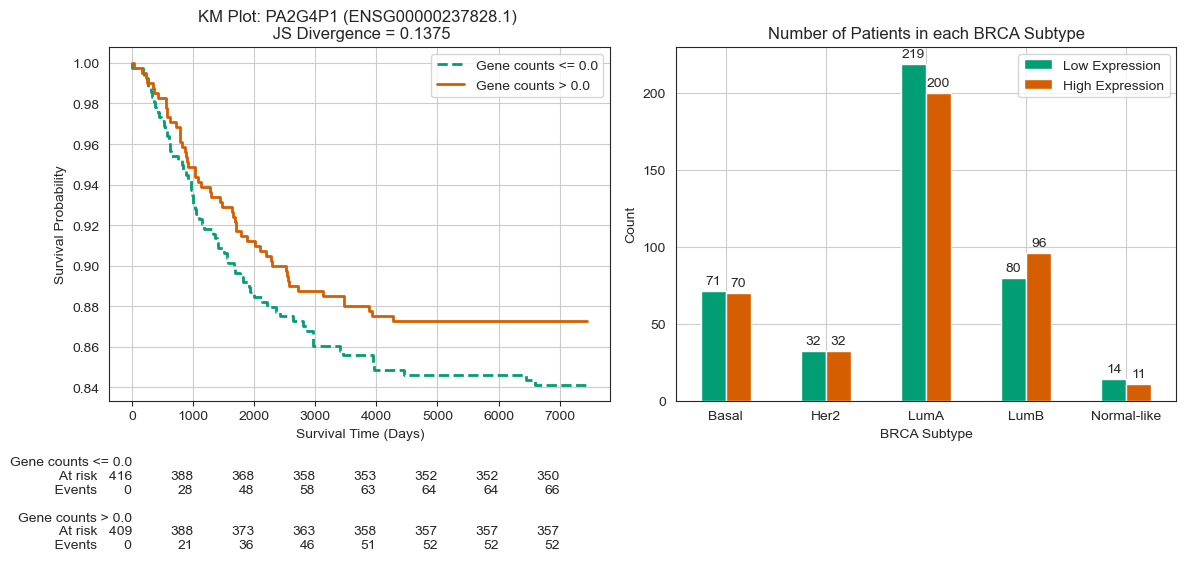

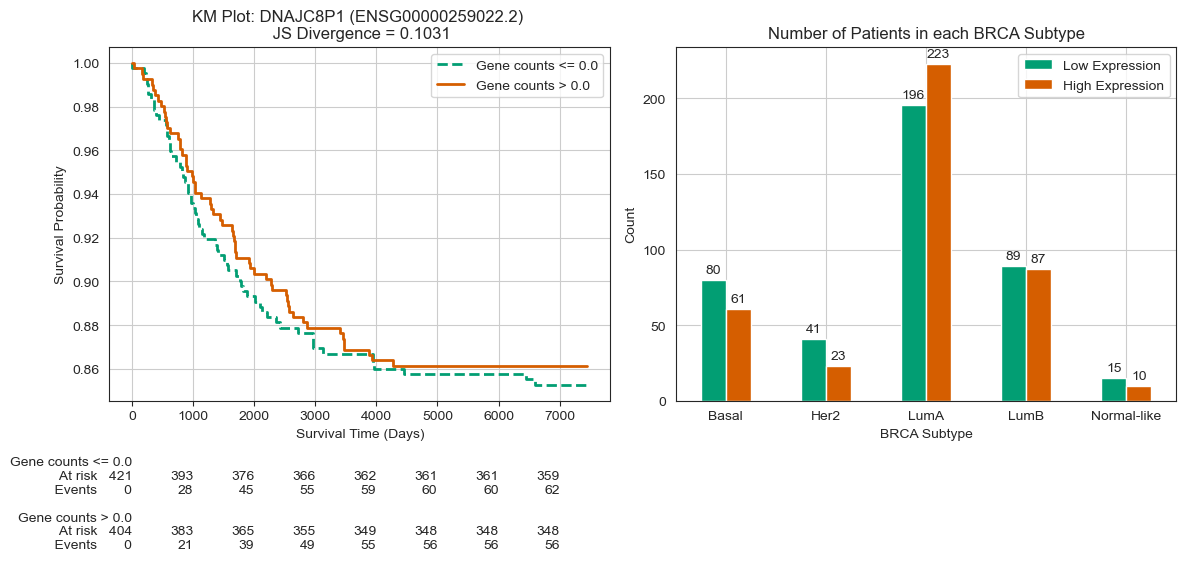

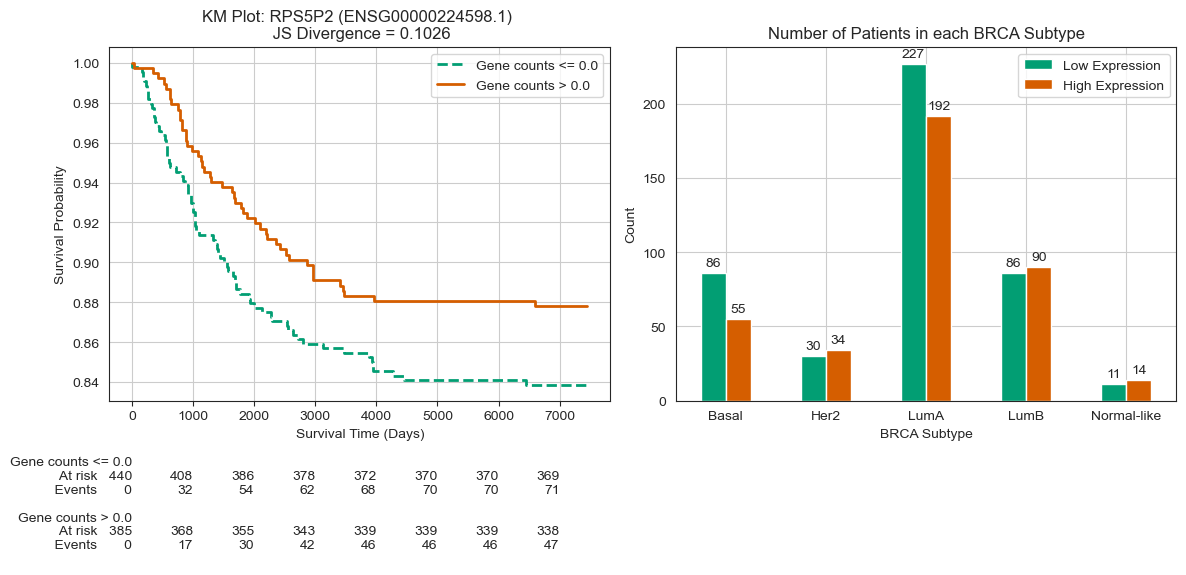

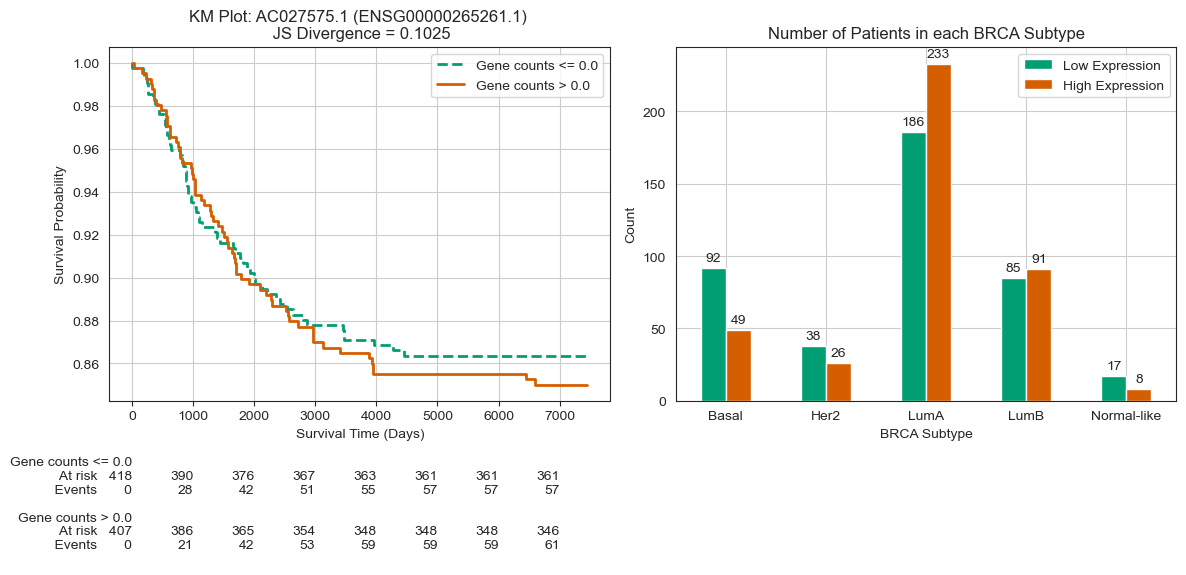

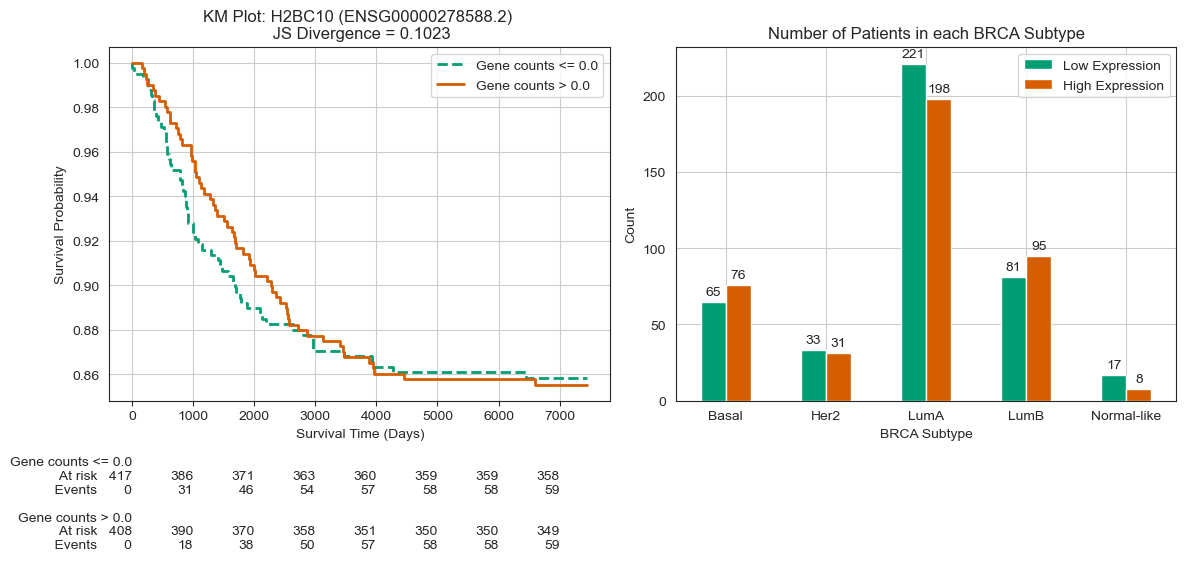

In [98]:
for i, gene in enumerate(gene_list[:5]):

    # Get gene count of that gene
    row = pd.to_numeric(df_with_subtype.loc[gene].values, errors='coerce')

    # Get optimal threshold for that gene
    tbl = jsd_result[jsd_result['gene'] == gene]
    median = gene_to_median[gene]

    # Extract days to death
    time_g1 = survival_time[row <= median]
    time_g2 = survival_time[row > median]
    
    # Extract status
    status_g1 = status[row <= median]
    status_g2 = status[row > median]

    # Extract KS_statistics
    jsd = round(tbl['JSD'].values[0], 4)
    text = f"JS Divergence = {jsd}"

    # Fit KaplanMeierFitter
    kmf_1 = KaplanMeierFitter()
    kmf_2 = KaplanMeierFitter()
    kmf_1.fit(time_g1, status_g1, label=f"Gene counts <= {round(median, 4)}")
    kmf_2.fit(time_g2, status_g2, label=f"Gene counts > {round(median, 4)}")

    # Plot Kaplan-Meier survival functions
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Top subplot
    ax = axs[0]
    kmf_1.plot_survival_function(ax=ax, ci_show=False, linestyle='dashed', linewidth=2, color=sns.color_palette('colorblind')[2])
    kmf_2.plot_survival_function(ax=ax, ci_show=False, linestyle='solid', linewidth=2, color=sns.color_palette('colorblind')[3])
    add_at_risk_counts(kmf_1, kmf_2, ax=ax, rows_to_show=['At risk', 'Events'])

    ax.set_title(f"KM Plot: {gene_id_to_name.get(gene, gene)} ({gene}) \n {text}")
    ax.set_xlabel("Survival Time (Days)")
    ax.set_ylabel("Survival Probability")
    ax.grid(True)
    ax.legend()
    
    # Plot number of samples in each subtype
    # Extract subtypes
    type_g1 = subtypes[row <= median]
    type_g2 = subtypes[row > median]

    # Count occurrences of each unique type
    unique_values = np.unique(np.concatenate([type_g1, type_g2]))

    # Count occurrences for each unique value in type_g1 and type_g2
    counts_type1 = np.array([np.count_nonzero(type_g1 == val) for val in unique_values])
    counts_type2 = np.array([np.count_nonzero(type_g2 == val) for val in unique_values])

    # Create a DataFrame directly
    df = pd.DataFrame({
        'Count': unique_values,
        'Low Expression': counts_type1,
        'High Expression': counts_type2
    }).set_index('Count')

    # Bottom subplot
    ax = axs[1]
    df.plot(kind='bar', color=[palette[2], palette[3]], ax=ax)
    # Add numbers on top of the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline',
                    xytext=(0, 5),
                    textcoords='offset points')
    ax.set_xlabel('BRCA Subtype')
    ax.set_xticklabels(df.index, rotation=0)
    ax.set_ylabel('Count')
    ax.set_title('Number of Patients in each BRCA Subtype')
    ax.grid()
    plt.tight_layout()
    plt.show()